### 1. Load training / validation image dataset

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

data_root = './data/horse-or-human'

# define vectorize transformer
class VectorizeTransform:
    def __call__(self, img):
        return torch.reshape(img, (-1, ))

# compose image transformer
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    VectorizeTransform()    # for vectorizing input image
])

# load training dataset
train_data_path = data_root + '/train'
train_dataset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=2048,
    shuffle=True,
    num_workers=0
)

# load validation dataset
valid_data_path = data_root + '/validation'
valid_dataset = torchvision.datasets.ImageFolder(root=valid_data_path, transform=transform)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=2048,
    shuffle=True,
    num_workers=0
)


### 2. Make full batch from training / validation dataloader

In [0]:
def make_full_batch(dataloader):
  x = torch.tensor([])
  y = torch.tensor([], dtype=torch.long)

  for batch_idx, (x_batch, y_batch) in enumerate(dataloader):
    x = torch.cat([x, x_batch], dim=0)
    y = torch.cat([y, y_batch], dim=0)

  y = torch.reshape(y, (-1, 1))

  return x, y

# make full batch data
x_train, y_train = make_full_batch(train_loader)
x_valid, y_valid = make_full_batch(valid_loader)


### 3. Define model and functions for learning neural network

In [0]:
import math

# initialize weight according to activation type and fan in/out size
def initialize_weight(activation_type, fan_in, fan_out):
  base = torch.randn(fan_out, fan_in)

  coefficient = 0
  if activation_type in ['sigmoid', 'tanh']:
    # use xavier initializer
    coefficient = math.sqrt(1 / fan_in)
  elif activation_type in ['relu', 'lrelu']:
    # use he initializer
    coefficient = math.sqrt(2 / fan_in)
  else:
    # cannot initialize weight because activation type is invalid
    raise ValueError('invalid activation type')

  return coefficient * base

def activation(type, z):
  if type == 'sigmoid':
    return 1 / (1 + torch.exp(-z))
  elif type == 'tanh':
    return (torch.exp(z) - torch.exp(-z)) / (torch.exp(z) + torch.exp(-z))
  elif type == 'relu':
    return z * (z > 0)
  elif type == 'lrelu':
    z1 = z * (z > 0)
    z2 = 0.01 * z * (z <= 0)
    return z1 + z2
  else:
    raise ValueError('invalid activation type')

def diff_activation(type, a):
  if type == 'sigmoid':
    return a * (1 - a)
  elif type == 'tanh':
    return 1 - a**2
  elif type == 'relu':
    return a > 0
  elif type == 'lrelu':
    a1 = a > 0
    a2 = 0.01 * (a <= 0)
    return a1 + a2
  else:
    raise ValueError('invalid activation type')

def loss(y_pred, y):
  epsilon = 1e-12
  return -1 * torch.mean(
      y * torch.log(y_pred + epsilon) + (1 - y) * torch.log(1 - y_pred + epsilon)
  )

def accuracy(y_pred, y):
  answer = (y_pred >= 0.5).float()
  return torch.mean((answer == y).float())

class ThreeLayerNN:
  # initialize parameters for this neural network
  def __init__(self, input_size, hidden1_size, hidden2_size, output_size, activation_type):
    self.activation = activation_type
    self.params = {}

    self.params['w1'] = initialize_weight(activation_type, input_size, hidden1_size)
    self.params['b1'] = torch.zeros((1, hidden1_size))

    self.params['w2'] = initialize_weight(activation_type, hidden1_size, hidden2_size)
    self.params['b2'] = torch.zeros((1, hidden2_size))

    self.params['w3'] = initialize_weight('sigmoid', hidden2_size, output_size)
    self.params['b3'] = torch.zeros((1, output_size))

  def forward(self, x):
    w1, w2, w3 = self.params['w1'], self.params['w2'], self.params['w3']
    b1, b2, b3 = self.params['b1'], self.params['b2'], self.params['b3']

    results = {}

    z1 = torch.matmul(x, w1.T) + b1
    a1 = activation(self.activation, z1)

    z2 = torch.matmul(a1, w2.T) + b2
    a2 = activation(self.activation, z2)

    z3 = torch.matmul(a2, w3.T) + b3
    a3 = activation('sigmoid', z3)

    results['z1'], results['z2'], results['z3'] = z1, z2, z3
    results['a1'], results['a2'], results['a3'] = a1, a2, a3

    return results

  def backward(self, x, y, forward_results):
    w1, w2, w3 = self.params['w1'], self.params['w2'], self.params['w3']
    b1, b2, b3 = self.params['b1'], self.params['b2'], self.params['b3']

    z1, z2, z3 = forward_results['z1'], forward_results['z2'], forward_results['z3']
    a1, a2, a3 = forward_results['a1'], forward_results['a2'], forward_results['a3']

    batch_size = x.shape[0]

    dz3 = (a3 - y) / batch_size
    dw3 = torch.matmul(dz3.T, a2)
    db3 = torch.sum(dz3, axis=0)

    da2 = torch.matmul(dz3, w3)
    dz2 = diff_activation(self.activation, a2) * da2
    dw2 = torch.matmul(dz2.T, a1)
    db2 = torch.sum(dz2, axis=0)

    da1 = torch.matmul(dz2, w2)
    dz1 = diff_activation(self.activation, a1) * da1
    dw1 = torch.matmul(dz1.T, x)
    db1 = torch.sum(dz1, axis=0)

    grads = {}
    grads['w1'], grads['w2'], grads['w3'] = dw1, dw2, dw3
    grads['b1'], grads['b2'], grads['b3'] = db1, db2, db3

    return grads


### 4. Learning neural network and plot the results

In [0]:
import matplotlib.pyplot as plt

# learning the neural network
def learning_nn(nn, epoch_count, lr, debug=False):
  train_losses = []
  train_accs = []

  valid_losses = []
  valid_accs = []

  for epoch in range(epoch_count):
    # compute loss and accuracy at this epoch using training data
    train_forward_results = nn.forward(x_train)
    y_pred_train = train_forward_results['a3']
    train_losses.append(loss(y_pred_train, y_train))
    train_accs.append(accuracy(y_pred_train, y_train))

    # compute loss and accuracy at this epoch using validation data
    valid_forward_results = nn.forward(x_valid)
    y_pred_valid = valid_forward_results['a3']
    valid_losses.append(loss(y_pred_valid, y_valid))
    valid_accs.append(accuracy(y_pred_valid, y_valid))

    # backward propagation and update model parameters using training data
    grads = nn.backward(x_train, y_train, train_forward_results)
    nn.params['w1'] -= lr * grads['w1']
    nn.params['b1'] -= lr * grads['b1']
    nn.params['w2'] -= lr * grads['w2']
    nn.params['b2'] -= lr * grads['b2']
    nn.params['w3'] -= lr * grads['w3']
    nn.params['b3'] -= lr * grads['b3']

    if debug and epoch % 100 == 0:
      print(f'epoch: {epoch}')
      print(f'train loss: {train_losses[-1]}')
      print(f'validation loss: {valid_losses[-1]}')
      print(f'train accuracy: {train_accs[-1]}')
      print(f'validation accuracy: {valid_accs[-1]}\n\n')

  return train_losses, train_accs, valid_losses, valid_accs

# plot the results (learning curves and table)
def plot_results(train_losses, train_accs, valid_losses, valid_accs):
  epoch_count = range(1, len(train_losses) + 1)

  # plot the training and validation loss at every epoch
  plt.title('Loss at every iteration')
  plt.plot(epoch_count, train_losses, 'r-')
  plt.plot(epoch_count, valid_losses, 'b-')
  plt.legend(['Training Loss', 'Validation Loss'])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

  # plot the training and validation accuracy at every epoch
  plt.title('Accuracy at every iteration')
  plt.plot(epoch_count, train_accs, 'r-')
  plt.plot(epoch_count, valid_accs, 'b-')
  plt.legend(['Training Accuracy', 'Validation Accuracy'])
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.show()

  # present the table for the final accuracy and loss with training and validation datasets
  fig = plt.figure(dpi=80)
  ax = fig.add_subplot(1,1,1)
  table_data=[
      ["$\\bf{dataset}$", "$\\bf{loss}$", "$\\bf{accuracy}$"],
      ["training", train_losses[-1].item(), train_accs[-1].item()],
      ["validation", valid_losses[-1].item(), valid_accs[-1].item()],
  ]
  table = ax.table(cellText=table_data, loc='center', cellLoc='center')
  table.set_fontsize(14)
  table.scale(2,4)
  ax.axis('off')
  plt.show()

##### `g1, g2, g3` are Sigmoid

lr: 0.01



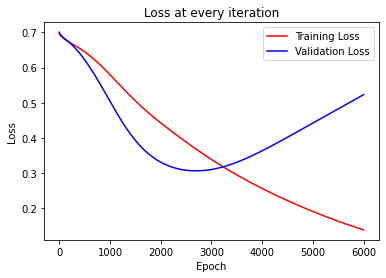

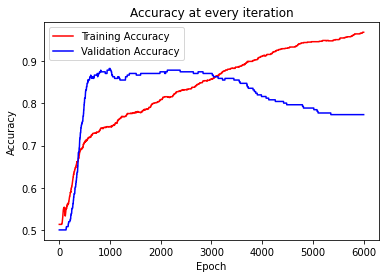

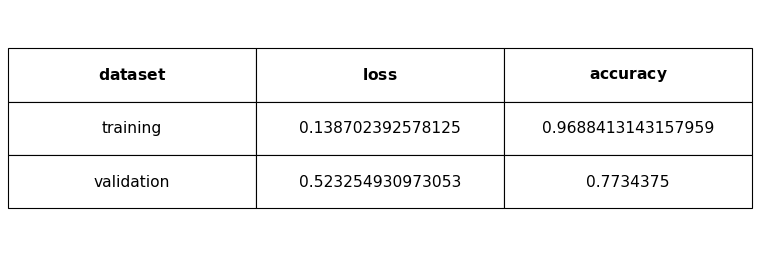

In [9]:
nn1 = ThreeLayerNN(x_train.shape[1], 100, 50, 1, 'sigmoid')
plot_results(*learning_nn(nn1, epoch_count=6000, lr=0.01))

##### `g1, g2` are tanh and `g3` is Sigmoid

In [0]:
nn2 = ThreeLayerNN(x_train.shape[1], 200, 100, 1, 'tanh')
plot_results(*learning_nn(nn2, epoch_count=1500, lr=0.042))

##### `g1, g2` are ReLU and `g3` is Sigmoid

In [0]:
nn3 = ThreeLayerNN(x_train.shape[1], 200, 100, 1, 'relu')
plot_results(*learning_nn(nn3, epoch_count=1500, lr=0.042))

##### `g1, g2` are Leaky ReLU and `g3` is Sigmoid

In [0]:
nn4 = ThreeLayerNN(x_train.shape[1], 200, 100, 1, 'lrelu')
plot_results(*learning_nn(nn4, epoch_count=1500, lr=0.042))